In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [16]:
class PollutionDataset(Dataset):
    def __init__(self, data, labels, seq_length):
        """
        Args:
            data (numpy array): 输入数据，形状为 (样本数, 时间步, 特征数)
            labels (numpy array): 输出标签，形状为 (样本数, 输出数)
            seq_length (int): 时间序列长度
        """
        self.data = data
        self.labels = labels
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [17]:
def create_sequences(data, labels, seq_length):
    """
    将数据切分为时间序列样本。
    Args:
        data (numpy array): 特征数据，形状为 (总时间点数, 特征数)
        labels (numpy array): 标签数据，形状为 (总时间点数,)
        seq_length (int): 时间步长
    Returns:
        X_seq (numpy array): 时间序列输入，形状为 (样本数, 时间步长, 特征数)
        y_seq (numpy array): 时间序列输出，形状为 (样本数,)
    """
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i+seq_length])
        y_seq.append(labels[i+seq_length])  # 标签对齐时间步的结束点
    return np.array(X_seq), np.array(y_seq)


In [18]:
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, cnn_filters, kernel_size, output_dim):
        """
        Args:
            input_dim (int): 输入特征数
            hidden_dim (int): LSTM 隐藏层维度
            cnn_filters (int): CNN 卷积核数量
            kernel_size (int): CNN 卷积核大小
            output_dim (int): 输出维度（预测目标数）
        """
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Conv1d(in_channels=input_dim, out_channels=cnn_filters, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=cnn_filters, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # 输入形状: (batch_size, seq_length, input_dim)
        x = x.permute(0, 2, 1)  # 转换为 (batch_size, input_dim, seq_length) 供 Conv1d 使用
        x = self.cnn(x)  # 卷积层
        x = self.pool(x)  # 池化层
        x = x.permute(0, 2, 1)  # 转换回 (batch_size, seq_length, cnn_filters)
        x, _ = self.lstm(x)  # LSTM 层
        x = x[:, -1, :]  # 获取 LSTM 的最后时间步输出
        x = self.fc(x)  # 全连接层
        return x


In [19]:
import pandas as pd
# 示例数据 (假设有 1000 个样本，时间步长为 24，特征数为 10)
time_steps = 24
num_features = 15
output_dim = 1  # 预测未来 1 小时的 PM2.5
df = pd.read_csv("../data/DataProcess/station/1037A/1037A_final.csv")
features = ['PM10', 'SO2', 'NO2', 'O3', 'CO', 'Dew_Point_2m',
       'Relative_Humidity_2m(%)', 'Temperature', 'Wind_Direction_10m',
       'Wind_Speed_10m(km/h)', 'Diffuse_Radiation(W/m2)',
       'Direct_Radiation(W/m2)', 'Precipitation(mm)',
       'Shortwave_Radiation(W/m2)', 'Surface_Pressure(hPa)']
target = 'Target'
X =  df[features].values
y =  df[target].values
num_samples =  len(df)
# 划分训练集和测试集
split_ratio = 0.8
split_index = int(num_samples * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 创建数据集和数据加载器
seq_length = time_steps



Epoch [1/5], Loss: 0.2321
Epoch [2/5], Loss: 0.1655
Epoch [3/5], Loss: 0.1521
Epoch [4/5], Loss: 0.1435
Epoch [5/5], Loss: 0.1366


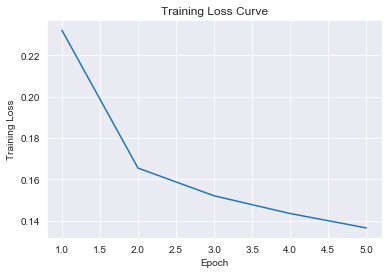

In [20]:
# 使用窗口化函数处理你的数据
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

# 打印检查数据形状
print(f"训练集输入形状: {X_train_seq.shape}, 训练集标签形状: {y_train_seq.shape}")
print(f"测试集输入形状: {X_test_seq.shape}, 测试集标签形状: {y_test_seq.shape}")

In [26]:
# 构造训练集和测试集
train_dataset = PollutionDataset(X_train_seq, y_train_seq, seq_length)
test_dataset = PollutionDataset(X_test_seq, y_test_seq, seq_length)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


torch.Size([8283, 10, 7])
torch.Size([8283, 1])


torch.Size([8283, 1])
Mean Squared Error on Test Data: 0.1902


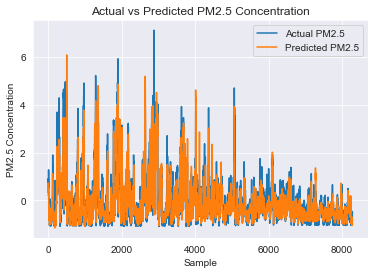

In [31]:
# 模型初始化
input_dim = num_features
hidden_dim = 64
cnn_filters = 32
kernel_size = 3
model = CNNLSTM(input_dim, hidden_dim, cnn_filters, kernel_size, output_dim)

# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

# 评估模型
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
    test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")


In [33]:
# 评估模型
model.eval()
test_loss = 0.0
predicted_values = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predicted_values.extend(outputs.tolist())
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
    test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")


RMSE: 0.4362, MAE: 0.2890, R2: 0.8182


In [13]:
print(predicted_values)

[[42.688961029052734], [42.6889762878418], [42.700016021728516], [42.68900680541992], [42.688968658447266], [42.68898010253906], [42.696720123291016], [42.79005432128906], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.79001998901367], [42.68919372558594], [42.688961029052734], [42.688961029052734], [42.688961029052734], [42.688961029052734], [42.688961029052734], [42.688961029052734], [42.688961029052734], [42.7397346496582], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.790061950683594], [42.78997039794922], [42.70072555541992], [42.68896484375], [42.688961029052734], [42.688961029052734], [4

RMSE: 39.4435
MAE: 27.4723
R^2: -0.0002


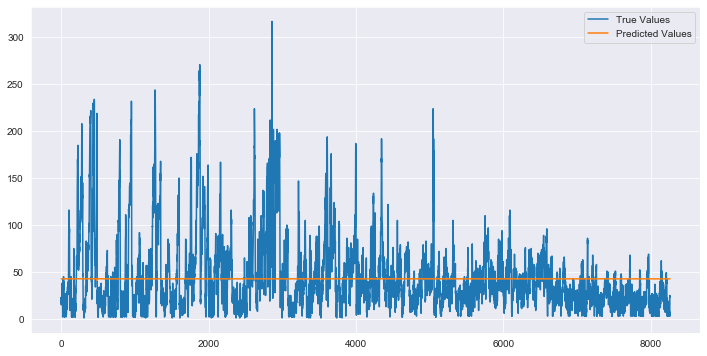

In [14]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
# 计算RMSE
rmse = np.sqrt(mean_squared_error(y_test_seq, predicted_values))
print(f"RMSE: {rmse:.4f}")
# 绘制预测值和真实值的对比图
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.legend()
plt.show()